## Setup


This notebook was originally written with the following versions:

    python 3.7.4
    fastai 1.0.57
    torch 1.2.0
    pandas 0.25.0
    numpy 1.16.4

##### Fastai: Useful links and commands to get setup:
Install anaconda3 on Linux (https://docs.anaconda.com/anaconda/install/linux/):

    wget https://repo.anaconda.com/archive/Anaconda3-2019.07-Linux-x86_64.sh
    bash ~/Anaconda3-2019.07-Linux-x86_64.sh

Enter an anaconda environment: 

    source anaconda3/bin/activate
    
Create new anaconda environment: 

    conda create -n myenv python=3.7.4

Enter conda environment:

    conda activate myenv
    
Install fastai + dependencies:

    conda install -c pytorch -c fastai fastai pytorch torchvision cuda92
    
    
##### Library Docs (for reference):
    
- fastai tabular: https://docs.fast.ai/tabular.data.html
- pandas dataframe: https://pandas.pydata.org/pandas-docs/stable/reference/frame.html
    


## Prepare Notebook

In [1]:
# Jupyter Notebook Magic

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import Modules

from fastai.tabular import *
from fastai.collab import *
import numpy as np
import pandas as pd
from pathlib import Path

import unittest

# Data Information

# filename = 'patient_year_vital_lab_exam_add-on_death_outcome_comorbidity_TCIC_dengue_suspected_bmi_ER_label_missing_mask.csv'
filename = 'patients_cleaned.csv'
path = Path('../mydata')

## Data Preparation

##### Convert CSV to Dataframe

In [2]:
# View all CSV column names
# df = pd.read_csv(path/filename, low_memory=False)
# "|".join(df.columns.tolist())

In [2]:
# Read CSV with desired columns
desired_cols = ['age','Temp','exam_WBC','exam_Plt','lab_result']
df = pd.read_csv(path/filename, usecols=desired_cols)

# Randomize data
df = df.iloc[np.random.permutation(len(df))]

# Convert dataframe types to float32 for fastai's tabular learner
df.astype('float32')

df.head()

,age,Temp,exam_Plt,exam_WBC,lab_result
4040,18,38.0,273.0,8.6,False
4404,74,38.5,207.0,15.8,False
1162,36,37.2,165.0,8.1,False
608,44,36.9,117.0,3.2,True
3847,21,37.8,171.0,5.0,True


#### Prepare Fastai Databunch

In [3]:
dep_var = 'lab_result' # target / dependent variable
cat_names = [] # categorical variables
cont_names = ['age','Temp','exam_Plt','exam_WBC'] # continuous variables
# procs = [FillMissing, Categorify, Normalize] # procs didn't work because no categorical variables were used


# Percent of original dataframe
test_pct = 0
valid_pct = 0.2

# Masks for separating dataframe sets
cut_test = int(test_pct * len(df))
cut_valid = int(valid_pct*len(df))+cut_test

valid_indx = range(cut_test,cut_valid) # range of validation indices, used for fastai
dep_var = 'lab_result'

test = TabularList.from_df(df.iloc[cut_test:cut_valid].copy(), cat_names=cat_names, cont_names=cont_names)

data = (TabularList.from_df(df=df, path=path, cat_names=cat_names, cont_names=cont_names)
                           .split_by_idx(valid_indx)
                           .label_from_df(cols=dep_var)
                           .add_test(test,label=0)
                           .databunch())

data.show_batch()

age,Temp,exam_Plt,exam_WBC,target
22.0000,38.1000,186.0000,6.8000,False
68.0000,36.8000,228.0000,15.2000,False
14.0000,36.5000,103.0000,2.6000,True
67.0000,39.1000,105.0000,4.9000,True
38.0000,36.6000,225.0000,3.6000,False


In [56]:
# valid = df[valid_indx[0]:valid_indx[-1]+1]  # same as data.valid_ds

## Training

In [33]:
# Tabular Classifier
learn = tabular_learner(data, layers=[200,100],metrics=accuracy) # metrics accuracy 200 100
# layers = [2000,1000,500,250,100]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 1.74E-02


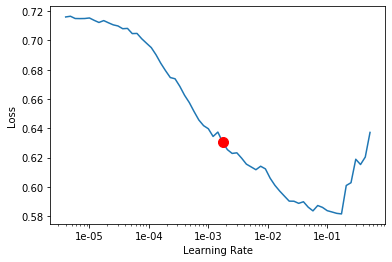

In [34]:
learn.lr_find()
learn.recorder.plot(skip_end=10,skip_start=20,suggestion=True)

In [57]:
data.batch_size

64

In [35]:
learn.fit_one_cycle(15,max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.526855,0.481300,0.793456,00:00
1,0.480883,0.444824,0.815951,00:00
2,0.469329,0.449991,0.804703,00:00
3,0.458127,0.449136,0.812883,00:00
4,0.452611,0.449268,0.810838,00:00
5,0.441594,0.450899,0.799591,00:00
6,0.444673,0.447144,0.812883,00:00
7,0.437062,0.448795,0.800614,00:00
8,0.437913,0.445944,0.806748,00:00
9,0.432482,0.437599,0.815951,00:00


## Results

In [73]:
preds, targets = learn.get_preds(DatasetType.Valid)
labels = np.argmax(preds, 1)

In [138]:
(targets == labels).type(torch.FloatTensor).mean().item() # accuracy

0.8231083750724792

In [139]:
preds

tensor([[0.8259, 0.1741],
        [0.2540, 0.7460],
        [0.0692, 0.9308],
        ...,
        [0.0501, 0.9499],
        [0.1867, 0.8133],
        [0.6522, 0.3478]])

In [132]:
compare = pd.DataFrame(targets == labels)
fi = list(compare[compare[0]==False].index.to_numpy()) # false indices
ti = list(compare[compare[0]==True].index.to_numpy()) # true indices

FN = len(labels[fi][labels[fi]==0]) # false negatives
FP = len(labels[fi][labels[fi]==1]) # false positives
TN = len(labels[ti][labels[ti]==0]) # true negatives
TP = len(labels[ti][labels[ti]==1]) # true positives

FN,FP,TN,TP

(56, 117, 279, 526)

In [153]:
assert len(data.valid_ds) == FN+FP+TN+TP

In [144]:
PPV = TP / (TP + FP) if (TP+FP != 0) else 0 # positive predict value
NPV = TN / (TN + FN) if (TN+FN != 0) else 0 # negative predict value
F1 = 2*TP / (2*TP + FP + FN) #
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP /(TP + FN) if (TP+FN != 0) else 0
specificity = TN /(TN + FP) if (TN+FP != 0) else 0
odds_ratio = (TP * TN) /(FP * FN) if (FP*FN != 0) else 0
total = FN+FP+TN+TP

results = [sensitivity, specificity, accuracy, PPV, NPV, F1, odds_ratio, TN, FP, FN, TP, total]
results_names = ['sensitivity', 'specificity', 'accuracy', 'PPV', 'NPV', 'F1', 'odds_ratio', 'TN', 'FP', 'FN', 'TP', 'total']

In [150]:
pd.DataFrame(data=[['Overall'] + results], columns=['df']+results_names)

,df,sensitivity,specificity,accuracy,PPV,NPV,F1,odds_ratio,TN,FP,FN,TP,total
0,Overall,0.90378,0.704545,0.823108,0.81804,0.832836,0.858776,22.398352,279,117,56,526,978


## Conclusion

The Fastai tabular learner network has the following architecture:

    (embeds): ModuleList()
      (emb_drop): Dropout(p=0.0, inplace=False)
      (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers): Sequential(
        (0): Linear(in_features=4, out_features=200, bias=True)
        (1): ReLU(inplace=True)
        (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Linear(in_features=200, out_features=100, bias=True)
        (4): ReLU(inplace=True)
        (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Linear(in_features=100, out_features=2, bias=True)
      )
    ), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of CrossEntropyLoss(), metrics=[<function accuracy at 0x7f50893ad560>], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('../mydata'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)], callbacks=[], layer_groups=[Sequential(
      (0): ModuleList()
      (1): Dropout(p=0.0, inplace=False)
      (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Linear(in_features=4, out_features=200, bias=True)
      (4): ReLU(inplace=True)
      (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Linear(in_features=200, out_features=100, bias=True)
      (7): ReLU(inplace=True)
      (8): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Linear(in_features=100, out_features=2, bias=True)
    )]